### Usando la base de datos BuzzFeed-Webis Fake News Corpus 2016 (la de artículos de izquierda, derecha, etc) y la vectorización de fasttext entrene dos módulos de PCA de dos componentes principales cada uno (uno con los datos de derecha y otro con los datos de izquierda)

In [2]:
!pip install fasttext
import fasttext
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import xml.etree.ElementTree as ET
from IPython.display import clear_output

!pip install nltk
import nltk
nltk.download('punkt')
clear_output()

if not os.path.exists("articles/"):
  !wget https://zenodo.org/record/1239675/files/articles.zip?download=1 -O articles.zip
  !unzip articles.zip
  !rm articles.zip
  clear_output()
  print("Data successfully downloaded")
else:
  print("Data already downloaded")


random_seed = 176249

Data already downloaded


In [8]:
if not os.path.exists("cc.en.300.bin"):
  # Más vectores de palabras en https://github.com/dccuchile/spanish-word-embeddings
  !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
  !gzip -d cc.en.300.bin.gz

--2022-09-27 15:29:13--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  39.5MB/s    in 98s     

2022-09-27 15:30:52 (43.7 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



In [9]:
model = fasttext.load_model('cc.en.300.bin')

El primer paso para ello es leer los datos. En este caso, se tiene un data frame con artículos de diarios y la anotación de la orientación política (left, right o mainstream).

In [10]:
def read_data(test_size=0.2,random_state=0):
  data = {
      # "author": [],
      # "title": [],
      "mainText": [],
      "orientation": [],
      # "veracity": []
  }
  index = []
  for filename in os.listdir("articles/"):
    root = ET.parse(f"articles/{filename}").getroot()
    index.append(int(filename.split(".")[0]))
    for elem in root:
      if elem.tag in data.keys():
        data[elem.tag].append(elem.text)
  data = pd.DataFrame(data,index=index)
  data = data[data.notna().all(axis="columns")]
  data = data.sample(frac=1,random_state=random_state)
  N = len(data)
  train_split, test_split = data.iloc[int(N*test_size):,:], data.iloc[:int(N*test_size),:]
  train_split = train_split.reset_index(drop=True)
  test_split = test_split.reset_index(drop=True)
  return train_split, test_split

Normalizo

In [11]:
def normalize_text(corpus,stop_words=None):

  # Convierto a lowercase
  corpus_lower = corpus.str.lower()

  # Elimino signos de puntuación, caracteres raros, etc.
  normalized_corpus = corpus_lower.str.replace(r"[^\w\d\s]+","",regex=True)

  # Elimino los stopwords
  if stop_words is not None:
    stop_words = "|".join(stop_words)
    normalized_corpus = normalized_corpus.str.replace(stop_words,"",regex=True)

  # Elimino espacios innecesarios
  normalized_corpus = normalized_corpus.str.replace(r"\s+"," ",regex=True)

  return normalized_corpus

Defino vocabulario

100%|██████████| 1284/1284 [00:02<00:00, 624.08it/s]


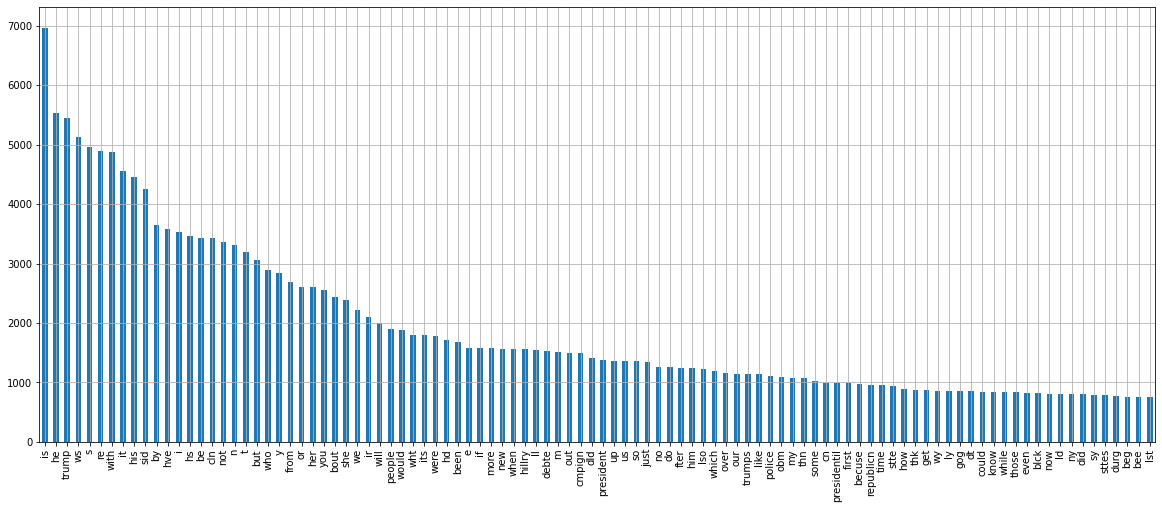

In [12]:
from nltk import word_tokenize
from collections import defaultdict

def create_vocabulary(corpus,tokenizer,max_tokens=40000,min_freq=1):
  counts = defaultdict(lambda: 0)
  for comment in tqdm(corpus):
    for token in tokenizer(comment):
      counts[token] += 1

  valid_tokens = sorted([tk for tk in counts.keys() if counts[tk] >= min_freq],key=counts.get,reverse=True)[:max_tokens]
  counts = [counts[tk] for tk in valid_tokens]
  return pd.Series(counts,index=valid_tokens)

train_data, test_data = read_data()
train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=["the","to","and","of","a","in","that","for","on","this","at","on"])
vocab = create_vocabulary(train_data["mainText"],word_tokenize,max_tokens=10000,min_freq=5)

fig, ax = plt.subplots(1,1,figsize=(20,8))
vocab[:100].plot(kind="bar",ax=ax,fontsize=10)
ax.grid(True)

Vectorización

In [13]:
def vectorize(corpus,tokenizer,vocab):
  N = len(vocab)
  corpus_size = len(corpus)
  X = np.zeros((len(corpus),N))

  token2idx = {tk: i for i, tk in enumerate(vocab.index)}
  for i, article in enumerate(tqdm(corpus)):
    for w in tokenizer(article):
      if w in vocab.index:
        idx = token2idx[w]
        X[i,idx] += 1
  
  return X

In [57]:
words_to_be_plotted = [
  "president", "trump", "police", "voters", "america", "government", "terrorism", "obamas",
  "violence", "terrorist", "islamic", "russian", "citizens", "crime", "racism", "freedom"
]

Izquierda

In [62]:
train_data, test_data = read_data()

train_data = train_data.loc[train_data['orientation'] == 'left',:]

train_data["mainText"] = normalize_text(train_data["mainText"])
test_data["mainText"] = normalize_text(test_data["mainText"])

vocab_left = create_vocabulary(train_data["mainText"],word_tokenize,max_tokens=10000,min_freq=5)
X_train = vectorize(train_data["mainText"],word_tokenize,vocab)
y_train = train_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

X_test = vectorize(test_data["mainText"],word_tokenize,vocab)
y_test = test_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

100%|██████████| 320/320 [00:00<00:00, 372.62it/s]


Matriz de words embeddings

In [63]:
word_embeddings_matrix_left = np.vstack([model[word] for word in vocab_left.keys()])

Cálculo de las componentes principales

In [64]:
from sklearn import decomposition

def plot_words2d(word_embeddings_matrix,words_to_be_plotted,x_lim=None,y_lim=None):
  """
  Función para graficar los vectores en dos dimensiones.

  Args:
    - word_embeddings_matrix: numpy.array de dimensión (n x d) con las
    representaciones de las palabras. (n = cantidad de palabras, d = dimensión
    de los vectores.)
    - words_to_be_plotted: lista de palabras correspondientes a las filas de la 
    matriz word_embeddings_matrix.
    - x_lim: tupla (float, float) con los límites del gráfico en la direción del 
    eje x.
    - y_lim: tupla (float, float) con los límites del gráfico en la direción del 
    eje y.

  """

  # Extraigo las primeras 2 componentes principales
  pca = decomposition.PCA(n_components=2)
  pca.fit(word_embeddings_matrix)
  words_to_be_plotted_casted = np.vstack([model[word] for word in words_to_be_plotted])
  principals = pca.transform(words_to_be_plotted_casted)

  # Si los límites son None, los seteo para inluir a todas las representaciones.
  if not x_lim:
    x_lim = (principals[:,0].min()*1.1, principals[:,0].max()*1.1)
  if not y_lim:
    y_lim = (principals[:,1].min()*1.1, principals[:,1].max()*1.1)

  # Grafico los puntos
  fig, ax = plt.subplots(1,1,figsize=(12,12))
  ax.plot(principals[:,0],principals[:,1],"o",ms=3)

  # Anoto las palabras
  for i, word in enumerate(words_to_be_plotted):
    if principals[i,0] <= x_lim[0] or principals[i,1] <= y_lim[0] or \
      principals[i,0] >= x_lim[1] or principals[i,1] >= y_lim[1]:
        continue
    ax.text(principals[i,0]*1.001,principals[i,1]*1.001,word,fontsize=15)

  ax.grid(True)
  ax.set_xlim(*x_lim)
  ax.set_ylim(*y_lim)
  fig.tight_layout()

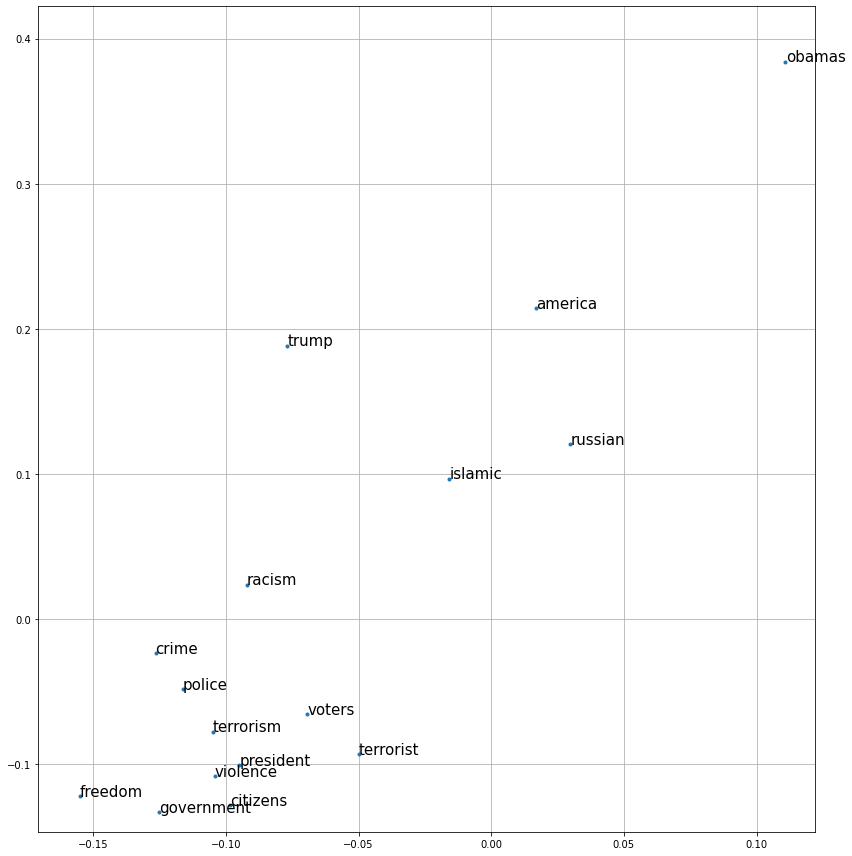

In [65]:
plot_words2d(word_embeddings_matrix_left,words_to_be_plotted,None,None)

Derecha

In [69]:
train_data, test_data = read_data()

train_data = train_data.loc[train_data['orientation'] == 'right',:]

train_data["mainText"] = normalize_text(train_data["mainText"])
test_data["mainText"] = normalize_text(test_data["mainText"])

vocab_right = create_vocabulary(train_data["mainText"],word_tokenize,max_tokens=10000,min_freq=5)
X_train = vectorize(train_data["mainText"],word_tokenize,vocab)
y_train = train_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

X_test = vectorize(test_data["mainText"],word_tokenize,vocab)
y_test = test_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

100%|██████████| 320/320 [00:01<00:00, 253.03it/s]


In [70]:
word_embeddings_matrix_left = np.vstack([model[word] for word in vocab_right.keys()])

In [71]:
from sklearn import decomposition

def plot_words2d(word_embeddings_matrix,words_to_be_plotted,x_lim=None,y_lim=None):
  """
  Función para graficar los vectores en dos dimensiones.

  Args:
    - word_embeddings_matrix: numpy.array de dimensión (n x d) con las
    representaciones de las palabras. (n = cantidad de palabras, d = dimensión
    de los vectores.)
    - words_to_be_plotted: lista de palabras correspondientes a las filas de la 
    matriz word_embeddings_matrix.
    - x_lim: tupla (float, float) con los límites del gráfico en la direción del 
    eje x.
    - y_lim: tupla (float, float) con los límites del gráfico en la direción del 
    eje y.

  """

  # Extraigo las primeras 2 componentes principales
  pca = decomposition.PCA(n_components=2)
  pca.fit(word_embeddings_matrix)
  words_to_be_plotted_casted = np.vstack([model[word] for word in words_to_be_plotted])
  principals = pca.transform(words_to_be_plotted_casted)

  # Si los límites son None, los seteo para inluir a todas las representaciones.
  if not x_lim:
    x_lim = (principals[:,0].min()*1.1, principals[:,0].max()*1.1)
  if not y_lim:
    y_lim = (principals[:,1].min()*1.1, principals[:,1].max()*1.1)

  # Grafico los puntos
  fig, ax = plt.subplots(1,1,figsize=(12,12))
  ax.plot(principals[:,0],principals[:,1],"o",ms=3)

  # Anoto las palabras
  for i, word in enumerate(words_to_be_plotted):
    if principals[i,0] <= x_lim[0] or principals[i,1] <= y_lim[0] or \
      principals[i,0] >= x_lim[1] or principals[i,1] >= y_lim[1]:
        continue
    ax.text(principals[i,0]*1.001,principals[i,1]*1.001,word,fontsize=15)

  ax.grid(True)
  ax.set_xlim(*x_lim)
  ax.set_ylim(*y_lim)
  fig.tight_layout()

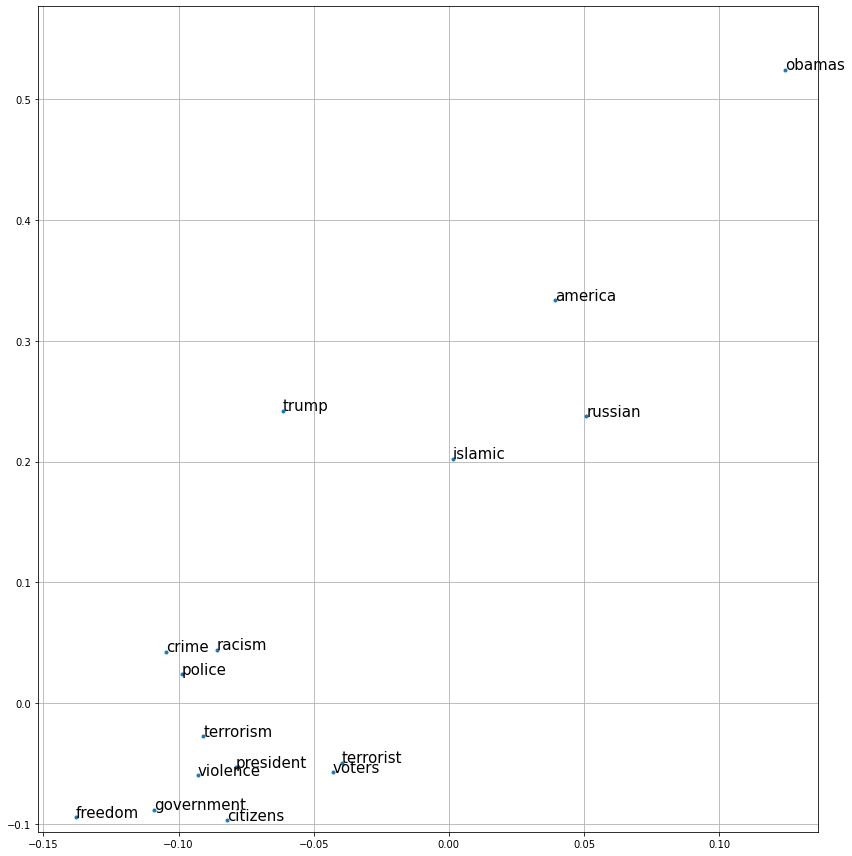

In [72]:
plot_words2d(word_embeddings_matrix_left,words_to_be_plotted,None,None)